# Guía 1 Python Gurobi

Autor: Mariana Ortega mvortega2@uc.cl 

### Características de Gurobi

Gurobi es un solver de optimización que se utiliza en casi dos docenas de industrias y más de 1400 empresas.
Soporta los siguientes tipos de problemas:
- Programación lineal (LP)
- Programación lineal entera mixta (MILP)
- Programación cuadrática (QP)
- Programación cuadrática entera mixta (MIQP)
- Programación restringido cuadráticamente (QCP)
- Programación entera mixta restringido cuadráticamente (MIQCP)

Gurobi es compatible con muchos lenguajes de modelado como AMPL, GAMS, AIMMS, y MPL, entre otros. También soporta un rango completo de lenguajes de programación orientados a objetos (C++, Java, .NET y Python) y matrices (C, Matlab y R).

### Fundamentos de la Programación Entera Mixta (MIP)

Un MIP es un problema en el que solo algunas de las variables tienen restricciones de integralidad.
El problema lineal continuo que se obtiene al omitir las restricciones de integralidad de las variables se denomina *relajación lineal* del problema.


#### Ramificación y acotamiento (Branch & Bound)

Los MIP son generalmente resueltos usando un algoritmo de branch & bound. El objetivo de este algoritmo es enumerar las soluciones de forma $\textit{
inteligente}$. Esto es, realizar una enumeración parcial, eliminando aquellas soluciones que pueden probarse no óptimas.
El algoritmo tiene dos etapas:

- Ramificación:
Particionar el conjunto factible de la relajación del problema en conjuntos más pequeños. Esto se realiza agregando restricciones. 
- Acotamiento: 
Resolver los subproblemas restantes de esta partición y, a partir del análisis de las soluciones obtenidas y de sus respectivos valores óptimos, establecer si es posible obtener mejores soluciones diviendo nuevamente algún subproblema o no. En el caso de concluir que de un subproblema no se podrán obtener mejores soluciones que las obtenidas hasta el momneto, este subproblema no se ramifica. 

Por tanto, en cada etapa de b&b se escoge uno de los subproblemas candidatos y se resuelve.



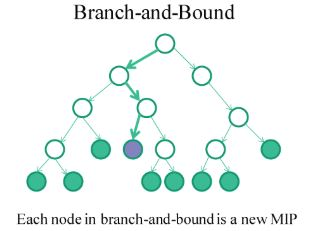

##### Incumbente y nodos podados

Para entender algunos parámetros que nos entrega el solver de Gurobi debemos profundizar en la lógica del B&B al procesar los nodos del árbol de búsqueda. 
Asumamos que nuestra función objetivo es de minimización y supongamos que acabamos de resolver una relajación lineal de algún nodo en el árbol de búsqueda. Si sucede que todas las restricciones de integralidad en el MIP original se satisfacen en la solución de este nodo, entonces sabemos que es un nodo $\textit{factible}$ para el MIP original. Desde aquí debemos seguir dos pasos:
- Primero, designamos este nodo como podado. Esto es, no es necesario seguir ramificando este nodo. Es una hoja permanente del árbol de búsqueda.
- Segundo, analizar la información que nos entrega esta solución factible de la siguiente forma. Denotemos la mejor solución entera encontrada en cualquier momento de la búsqueda como el $\textit{incumbente}$. Al comienzo de la búsqueda no tenemos incumbente. Si la solución entera factible que acabamos de encontrar tiene un valor de la función objetivo mejor que el incumbente actual (o si no tenemos incumbente), entonces guardamos esta solución junto a su valor objetivo como el nuevo incumbente. En el caso contrario no se actualiza el incumbente y procedemos con la búsqueda en otro subproblema. 

Existen otras dos posibilidades que llevan a que podemos un nodo. Primero, puede suceder que la rama que llevó al nodo actual agregó una restricción que hizo que la relajación lineal se volviera infactible. Claramente, si el nodo no tiene una solución factible para la relajación lineal tampoco tendrá una solución entera factible. La segunda posibilidad es que se encuentre una solución óptima de la relajación del problema, pero su valor objetivo sea peor (en este caso más grande) que el incumbente actual. Obviamente este nodo no púede devolver una mejor solución entera y por tanto puede ser podado.  

### Otros algoritmos MIP
Gurobi también ocupa otros algoritmos para resolver eficazmente los MIP, los cuales debemos aprender para entender luego la información que nos entrega el software.  

##### Presolve
Se refiere a una serie de reducciones del problema que generalmente se realizan antes de comenzar el algoritmo de b&b con el objetivo de reducir el tamaño del problema.
Por ejemplo, supongamos que tenemos un MIP con variables $x_1$ y $x_2$ enteros no negativos y que nuestra formulación incluye la siguiente restricción:

$$2x_1 + 2x_2 \leq 1$$ 
Diviendo ambos lados de la restricción por 2 se tiene,

$$x_1 + x_2 \leq 1/2$$
Como se requiere que $x_1$ y $x_2$ sean enteros esta última inecuación implica que $x_1 + x_2 \leq 0$ y por no negatividad se tiene que $x_1 = x_2 = 0$. Por tanto, estas variables y restricción pueden ser removidas de la formulación. 

##### Planos cortantes
La idea de los planos cortantes es que aprietan la formulación al remover soluciones fraccionales no deseadas $\textit{durante}$ el proceso de solución sin crear subproblemas adicionales como en la ramificación.
Por ejemplo, supongamos un problema donde todas las variables son binarias y tenemos la siguiente restricción:
$$6x_1 + 5x_2 + 7x_3 + 4x_4 + 5x_5 \leq 15$$
Supongamos además que acabamos de resolver la relajación lineal del problema y las variables toman los siguientes valores en esa relajación: $$x_1 = 0, x_2 = 1, x_3 = x_4 = x_5 = 3/4$$ Esta solución no deseada puede ser excluida al realizar la siguiente observación: como $7+4+5=16 \gt 15$ entonces no es posible que $x_3 = x_4 = x_5$, por lo que resulta válido agregar la siguiente nueva inecuación al MIP: $x_3+x_4+x_5 \leq 2$. Como $3/4 + 3/4 + 3/4= 9/4 >2$, la nueva restricción $\textit{corta}$ el actual espacio solución. Esta inecuación es un ejemplo de un cover de la mochila. Otro ejemplos son los cortes de Gomory.
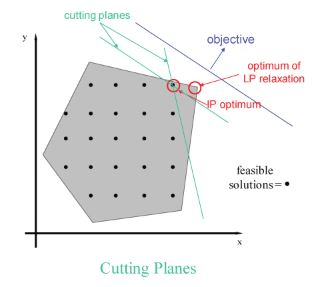

##### Heurísticas
Tener buenos incumbentes, y encontrarlos lo más rápido posible, puede ser extremadamente valioso en la búsqueda del árbol por muchas razones. Primero, puede que no sea posible resolver el problema hasta probar optimalidad. El problema puedde ser muy dificil o puede haber una restricción de tiempo impuesta por el usuario sobre la cantidad de tiempo que podemos permitir que nuestro algoritmo de MIP corra. En ambos casos queremos obtener la mejor solución factible al término. También, tener buenas soluciones factibles ayuda en el proceso de búsqueda antes del término. Mientras mejor sea el valor objetivo del incumbente es más probable que el valor de la función objetivo de la relajación lineal del problema sea peor (lo sobrepase en el caso de un problema de minimización) y por tanto podremos podar la rama. 

Como lo anterior sugiere resulta extremadamente valioso realizar un poco de trabajo extra en algunos nodos del árbol de búsqueda para ver si una buena solución entera factible puede ser extraída. Por ejemplo, puede suceder que muchas variables enteras, si bien todavía no integrales, tengan valores muy cercanos a los enteros. Aquí podríamos aproximar algunas de estas variables a sus valores cercanos, asignarles dichos valores, resolver la relajación lineal resultante y repetir este proceso varias veces esperando que todas las variables enteras se alineen. Si lo hacen y el resultado factible tiene un mejor valor objetivo que el incumbente, entonces podemos actualizar el incumbente y proceder. 
Tal como esta, Gurobi incluye múltiples y diversas de estas heurísticas para resolver problemas. 

##### Paralelismo
El solver MIP de gurobi corre en paralelo pues en el árbol de búsqueda de b&b diferentes nodos pueden ser procesados independientemente. Como se puede ver, el nodo raíz tiene oportunidades limitadas de paralelismo y por tanto existen diferentes acercamientos sobre la forma de explorar el nodo raíz, obteniendo una mayor o menor eficacia en el uso de los núcleos del computador. 
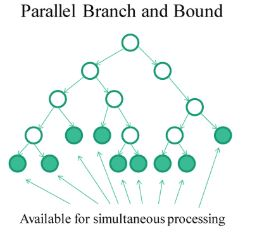